In [1]:
### This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predict-the-success-of-bank-telemarketing/sample_submission.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv


# Import Libraries

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix,roc_auc_score,f1_score,ConfusionMatrixDisplay, make_scorer

# Data Loading

In [3]:
sample_data=pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/sample_submission.csv")
train_data=pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv")
test_data=pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv")

# Dummy Classifier

In [4]:
from sklearn.dummy import DummyClassifier

X=train_data.drop(columns='target')
y=train_data['target']
dummy_clf = DummyClassifier(strategy="stratified")  
dummy_clf.fit(X, y)
y_pred = dummy_clf.predict(test_data)

submission=pd.DataFrame({'id':range(1,len(y_pred)+1),'target':y_pred})
submission.to_csv('submission.csv',index=False)

# Examine the data

In [5]:
test_data.head()

,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome
0,2009-11-21,36,management,single,tertiary,no,7,no,no,NaN,20,1,-1,0,NaN
1,2010-02-04,30,unemployed,married,tertiary,no,1067,no,no,cellular,78,2,-1,0,NaN
2,2010-07-28,32,blue-collar,single,secondary,no,82,yes,no,cellular,86,4,-1,0,NaN
3,2010-06-09,38,admin.,married,primary,no,1487,no,no,NaN,332,2,-1,0,NaN
4,2008-03-02,59,management,married,tertiary,no,315,no,no,cellular,591,1,176,2,failure


In [6]:
test_data.shape

(10000, 15)

In [7]:
train_data.head()

,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,target
0,2009-04-17,26,blue-collar,married,secondary,no,647,yes,no,cellular,357,2,331,1,other,no
1,2009-10-11,52,technician,married,secondary,no,553,yes,no,telephone,160,1,-1,0,NaN,no
2,2010-11-20,44,blue-collar,married,secondary,no,1397,no,no,cellular,326,1,-1,0,NaN,no
3,2009-09-01,33,admin.,married,secondary,no,394,yes,no,telephone,104,3,-1,0,NaN,no
4,2008-01-29,31,entrepreneur,single,tertiary,no,137,no,no,cellular,445,2,-1,0,NaN,no


- Some rows contain missing values, particularly in contact and poutcome.
- The duration and balance fields vary widely, potentially reflecting different levels of customer engagement and financial capacity.
- Campaign and Previous field show customer engagement through the number of contacts, which might impact customer response.

In [8]:
train_data.tail()

,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,target
39206,2008-07-31,31,technician,single,secondary,no,0,yes,no,cellular,16,34,-1,0,NaN,no
39207,2009-07-31,59,admin.,married,primary,no,6187,no,no,cellular,114,4,-1,0,NaN,no
39208,2008-06-02,36,blue-collar,married,secondary,no,63,yes,no,NaN,56,8,-1,0,NaN,no
39209,2010-03-20,28,student,single,secondary,no,5916,no,no,cellular,93,5,-1,0,NaN,no
39210,2010-03-16,51,student,divorced,tertiary,yes,38594,yes,no,cellular,1877,19,780,148,success,yes


In [9]:
train_data.shape

(39211, 16)

### Info

In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39211 entries, 0 to 39210
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   last contact date  39211 non-null  object
 1   age                39211 non-null  int64 
 2   job                38982 non-null  object
 3   marital            39211 non-null  object
 4   education          37744 non-null  object
 5   default            39211 non-null  object
 6   balance            39211 non-null  int64 
 7   housing            39211 non-null  object
 8   loan               39211 non-null  object
 9   contact            28875 non-null  object
 10  duration           39211 non-null  int64 
 11  campaign           39211 non-null  int64 
 12  pdays              39211 non-null  int64 
 13  previous           39211 non-null  int64 
 14  poutcome           9760 non-null   object
 15  target             39211 non-null  object
dtypes: int64(6), object(10)
memory usage: 4.

### Describe

In [11]:
train_data.describe()

,age,balance,duration,campaign,pdays,previous
count,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000
mean,42.120247,5441.781719,439.062789,5.108770,72.256051,11.826171
std,12.709352,16365.292065,769.096291,9.890153,160.942593,44.140259
min,18.000000,-8019.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,98.000000,109.000000,1.000000,-1.000000,0.000000
50%,40.000000,549.000000,197.000000,2.000000,-1.000000,0.000000
75%,50.000000,2030.000000,380.000000,4.000000,-1.000000,0.000000
max,95.000000,102127.000000,4918.000000,63.000000,871.000000,275.000000


- **Age**: Average age is 42.12 years, with most customers aged between 33 and 50.
- **Balance**: Mean balance is 5441.78, but most customers have balances between 98 and 2030, with large outliers.
- **Duration**: Average call duration is 439.06 seconds, with most calls lasting between 109 and 380 seconds.
- **Campaign**: On average, customers were contacted 5.11 times, but most were contacted between 1 and 4 times.
- **Pdays**: Average days since last contact is 72.26, though many customers were never contacted before.
- **Previous**: Mean number of previous contacts is 11.83, but most customers had no previous contacts.


In [12]:
train_data.columns

Index(['last contact date', 'age', 'job', 'marital', 'education', 'default',
       'balance', 'housing', 'loan', 'contact', 'duration', 'campaign',
       'pdays', 'previous', 'poutcome', 'target'],
      dtype='object')

### Number of Unique values

In [13]:
train_data.nunique()

last contact date    1013
age                    78
job                    11
marital                 3
education               3
default                 2
balance              9535
housing                 2
loan                    2
contact                 2
duration             3146
campaign               63
pdays                 865
previous              276
poutcome                3
target                  2
dtype: int64

In [14]:
categorical_cols = []
for i in train_data.columns:
    print(f"{i} : {train_data[i].nunique()}")
    if int(train_data[i].nunique())<=15:
        categorical_cols.append(i)
categorical_cols

last contact date : 1013
age : 78
job : 11
marital : 3
education : 3
default : 2
balance : 9535
housing : 2
loan : 2
contact : 2
duration : 3146
campaign : 63
pdays : 865
previous : 276
poutcome : 3
target : 2


['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'poutcome',
 'target']

### Null values in dataset

In [15]:
train_data.isna().sum()

last contact date        0
age                      0
job                    229
marital                  0
education             1467
default                  0
balance                  0
housing                  0
loan                     0
contact              10336
duration                 0
campaign                 0
pdays                    0
previous                 0
poutcome             29451
target                   0
dtype: int64

- Job, Education, Contact and Poutcome have null value

In [16]:
train_data.isna().sum()/len(train_data)*100

last contact date     0.000000
age                   0.000000
job                   0.584020
marital               0.000000
education             3.741297
default               0.000000
balance               0.000000
housing               0.000000
loan                  0.000000
contact              26.359950
duration              0.000000
campaign              0.000000
pdays                 0.000000
previous              0.000000
poutcome             75.109026
target                0.000000
dtype: float64

### Value counts


In [17]:
categorical_cols

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'poutcome',
 'target']

In [18]:
for i in categorical_cols:
    print(train_data[i].value_counts()/len(train_data)*100)
    print()

job
blue-collar      19.831170
management       19.030374
technician       15.500752
admin.           10.497054
services          8.479763
self-employed     4.748667
retired           4.651756
entrepreneur      4.603300
unemployed        4.297264
housemaid         4.223305
student           3.552575
Name: count, dtype: float64

marital
married     57.868965
single      28.690929
divorced    13.440106
Name: count, dtype: float64

education
secondary    49.945168
tertiary     29.621790
primary      16.691745
Name: count, dtype: float64

default
no     94.243962
yes     5.756038
Name: count, dtype: float64

housing
yes    55.23195
no     44.76805
Name: count, dtype: float64

loan
no     81.150698
yes    18.849302
Name: count, dtype: float64

contact
cellular     63.834128
telephone     9.805922
Name: count, dtype: float64

poutcome
failure    12.621458
other       6.528780
success     5.740736
Name: count, dtype: float64

target
no     85.139374
yes    14.860626
Name: count, dtype: float6

- Job: Most customers are in blue-collar (19.83%), management (19.03%), or technician (15.50%) roles.
- Marital Status: Majority are married (57.87%), followed by single (28.69%) and divorced (13.44%).
- Education: Nearly half have secondary education (49.95%), with tertiary (29.62%) and primary (16.69%) following.
- Default: Vast majority have no credit default (94.24%).
- Housing Loan: Slightly more than half have a housing loan (55.23%).
- Personal Loan: Most customers do not have a personal loan (81.15%).
- Contact: Most communication was via cellular (63.83%), with telephone at (9.81%).
- Previous Outcome (poutcome): Outcome of prior campaigns shows a high rate of failure (12.62%) and some success (5.74%).
- Target (Response): Majority of customers did not respond positively (85.14%) to the campaign.


# **EDA(Exploratory Data Analysis)**

##### Univariate analysis---> Analysis of single column and also patterns with target  columns
##### Multivariate analysis----> Patterns between columns.

## Univariate analysis

In [19]:
train_data.columns

Index(['last contact date', 'age', 'job', 'marital', 'education', 'default',
       'balance', 'housing', 'loan', 'contact', 'duration', 'campaign',
       'pdays', 'previous', 'poutcome', 'target'],
      dtype='object')

### last contact date


In [20]:
train_data['last contact date'].describe()

count          39211
unique          1013
top       2009-05-15
freq             313
Name: last contact date, dtype: object

- The most common contact date is May 15, 2009, with 313 occurrences, indicating a campaign peak or focused outreach.

In [21]:
train_data['last contact date'] = pd.to_datetime(train_data['last contact date'])
train_data['year'] = train_data['last contact date'].dt.year
train_data['month'] = train_data['last contact date'].dt.month
train_data['weekday'] = train_data['last contact date'].dt.weekday

In [22]:
train_data.head()

,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,target,year,month,weekday
0,2009-04-17,26,blue-collar,married,secondary,no,647,yes,no,cellular,357,2,331,1,other,no,2009,4,4
1,2009-10-11,52,technician,married,secondary,no,553,yes,no,telephone,160,1,-1,0,NaN,no,2009,10,6
2,2010-11-20,44,blue-collar,married,secondary,no,1397,no,no,cellular,326,1,-1,0,NaN,no,2010,11,5
3,2009-09-01,33,admin.,married,secondary,no,394,yes,no,telephone,104,3,-1,0,NaN,no,2009,9,1
4,2008-01-29,31,entrepreneur,single,tertiary,no,137,no,no,cellular,445,2,-1,0,NaN,no,2008,1,1


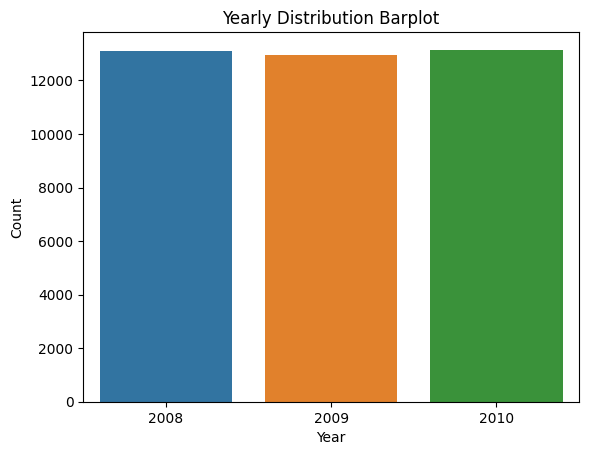

In [23]:
year_counts = train_data['year'].value_counts().sort_index()
sns.barplot(x=year_counts.index, y=year_counts.values)
plt.title("Yearly Distribution Barplot")
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()


- The dataset shows a balanced yearly distribution of entries across 2008, 2009, and 2010, indicating consistent data collection or campaign activity.

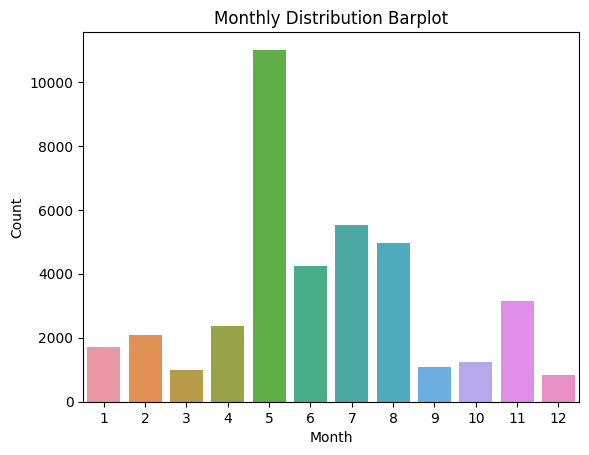

In [24]:
month_value_counts = train_data['month'].value_counts().sort_index()
sns.barplot(x=month_value_counts.index, y=month_value_counts.values)
plt.title("Monthly Distribution Barplot")
plt.xlabel("Month")
plt.ylabel("Count")
plt.show()


- May has the highest contact count by a significant margin, while contacts are lowest in December and the early months of the year.

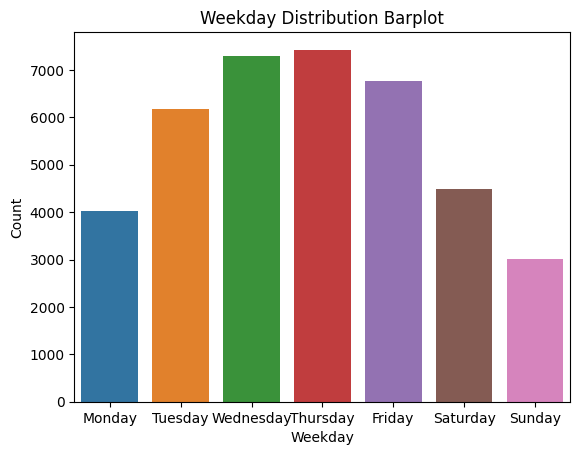

In [25]:
train_data['weekday'] = train_data['last contact date'].dt.weekday  
weekday_value_counts = train_data['weekday'].value_counts().sort_index()
sns.barplot(x=weekday_value_counts.index, y=weekday_value_counts.values)
plt.title("Weekday Distribution Barplot")
plt.xlabel("Weekday")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()

- The highest contact counts occur mid-week (Wednesday and Thursday), with fewer contacts on weekends, especially Sunday.

### Age

In [26]:
train_data[train_data['age']<=0].shape[0]

0

In [27]:
train_data['age'].describe()

count    39211.000000
mean        42.120247
std         12.709352
min         18.000000
25%         33.000000
50%         40.000000
75%         50.000000
max         95.000000
Name: age, dtype: float64

- The `age` column contains 39,211 entries with a mean age of approximately 42 years.
- The age distribution has a standard deviation of 12.71, indicating moderate spread around the mean.
- The minimum age is 18, and the maximum is 95.
- The 25th percentile age is 33, the median (50th percentile) is 40, and the 75th percentile is 50, showing that the majority of the values lie between 33 and 50 years.


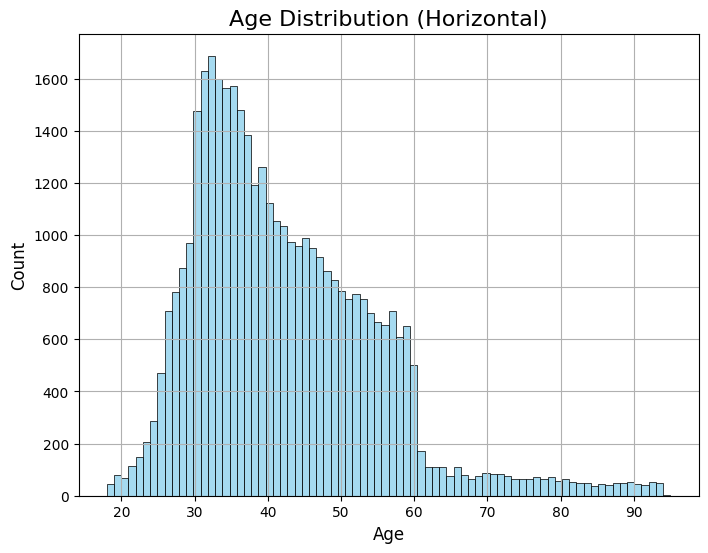

In [28]:
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(8, 6))
sns.histplot(
    data=train_data,              
    x='age',                 
    bins=78,                 
    color='skyblue',         
    edgecolor='black',       
    kde=False,               
    orientation='horizontal'
)
plt.title("Age Distribution (Horizontal)", fontsize=16)
plt.ylabel("Count", fontsize=12)
plt.xlabel("Age", fontsize=12)
plt.grid(visible=True)
plt.show()


- The age distribution is right-skewed, with a peak around the early 30s and a gradual decline in counts for ages above 40.

### Job


In [29]:
train_data['job'].value_counts()

job
blue-collar      7776
management       7462
technician       6078
admin.           4116
services         3325
self-employed    1862
retired          1824
entrepreneur     1805
unemployed       1685
housemaid        1656
student          1393
Name: count, dtype: int64

In [30]:
train_data['job'].describe()

count           38982
unique             11
top       blue-collar
freq             7776
Name: job, dtype: object

- The `job` column contains 38,982 entries with 11 unique job types.
- The most common job type is **blue-collar**, which appears **7,776** times, indicating a significant prevalence among the dataset.
- The presence of multiple job types suggests a diverse set of occupations in the dataset.


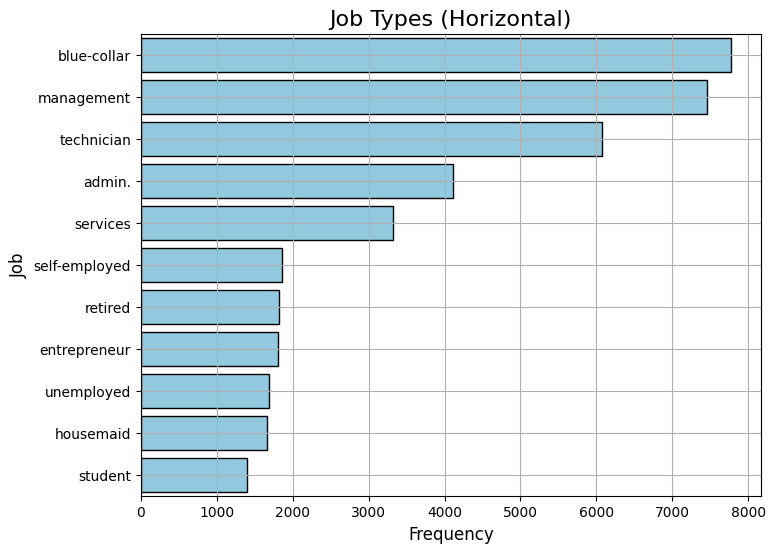

In [31]:
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(8, 6))
sns.barplot(
    data=train_data,              
    x=train_data['job'].value_counts().values,  
    y=train_data['job'].value_counts().index,   
    color='skyblue',              
    edgecolor='black',           
)
plt.title("Job Types (Horizontal)", fontsize=16)
plt.ylabel("Job", fontsize=12)
plt.xlabel("Frequency", fontsize=12)
plt.grid(visible=True)
plt.show()

### Marital

In [32]:
train_data['marital'].value_counts()

marital
married     22691
single      11250
divorced     5270
Name: count, dtype: int64

In [33]:
train_data['marital'].describe()

count       39211
unique          3
top       married
freq        22691
Name: marital, dtype: object



- **Total Count**: The `marital` column contains **39,211** entries.
- **Unique Values**: There are **3 unique marital statuses** represented in the dataset.
- **Most Frequent Category**: The most common marital status is **"married"**, with a frequency of **22,691** occurrences.
- **Top Category Proportion**: The **"married"** status represents about **57.9%** of the total entries in the dataset.


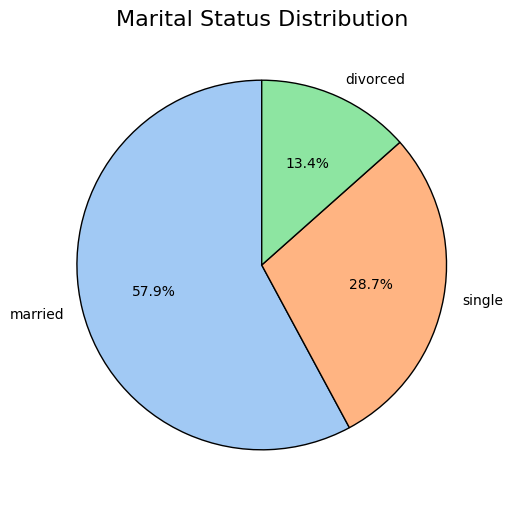

In [34]:
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(8, 6))
marital_counts = train_data['marital'].value_counts()
plt.pie(
    marital_counts.values,           
    labels=marital_counts.index,     
    autopct='%1.1f%%',               
    colors=sns.color_palette('pastel'), 
    startangle=90,                   
    wedgeprops={'edgecolor': 'black'} 
)

plt.title("Marital Status Distribution", fontsize=16)
plt.show()


### Education

In [35]:
train_data['education'].value_counts()

education
secondary    19584
tertiary     11615
primary       6545
Name: count, dtype: int64

In [36]:
train_data['education'].describe()

count         37744
unique            3
top       secondary
freq          19584
Name: education, dtype: object



- The majority of entries in the `education` column fall under the "secondary" level, indicating that over half of the dataset's individuals have this education level.


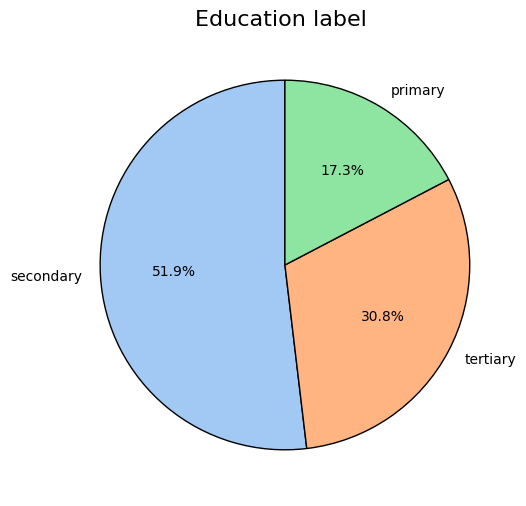

In [37]:
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(8, 6))
marital_counts = train_data['education'].value_counts()
plt.pie(
    marital_counts.values,           
    labels=marital_counts.index,     
    autopct='%1.1f%%',               
    colors=sns.color_palette('pastel'),  
    startangle=90,                   
    wedgeprops={'edgecolor': 'black'} 
)
plt.title("Education label ", fontsize=16)
plt.show()

### Default

In [38]:
train_data['default'].value_counts()

default
no     36954
yes     2257
Name: count, dtype: int64

In [39]:
train_data['default'].describe()

count     39211
unique        2
top          no
freq      36954
Name: default, dtype: object

- The `default` column primarily consists of the value "no," indicating that most records have no default status, while a minority hold the other unique value.

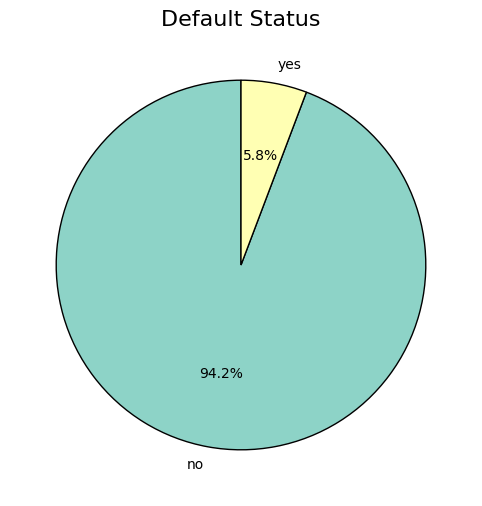

In [40]:
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(8, 6))
default_counts = train_data['default'].value_counts()
plt.pie(
    default_counts.values,           
    labels=default_counts.index,    
    autopct='%1.1f%%',                 
    colors=sns.color_palette('Set3'),  
    startangle=90,                     
    wedgeprops={'edgecolor': 'black'}  
)
plt.title("Default Status", fontsize=16)
plt.show()

### Balance

In [41]:
negative_balance_rows = train_data[train_data['balance'] <= 0]
negative_balance_rows.shape[0]

5770

In [42]:
train_data['balance'].value_counts()

balance
0        2799
1         149
2         122
4         115
3         104
         ... 
95094       1
81074       1
31565       1
5278        1
38594       1
Name: count, Length: 9535, dtype: int64

In [43]:
train_data['balance'].describe()

count     39211.000000
mean       5441.781719
std       16365.292065
min       -8019.000000
25%          98.000000
50%         549.000000
75%        2030.000000
max      102127.000000
Name: balance, dtype: float64

The `balance` column displays significant variability, with a wide range from -8,019 to 102,127. Most customers hold relatively modest balances, as reflected in the 25th, median, and 75th percentiles, while a few accounts hold considerably higher values, contributing to a large mean and standard deviation.

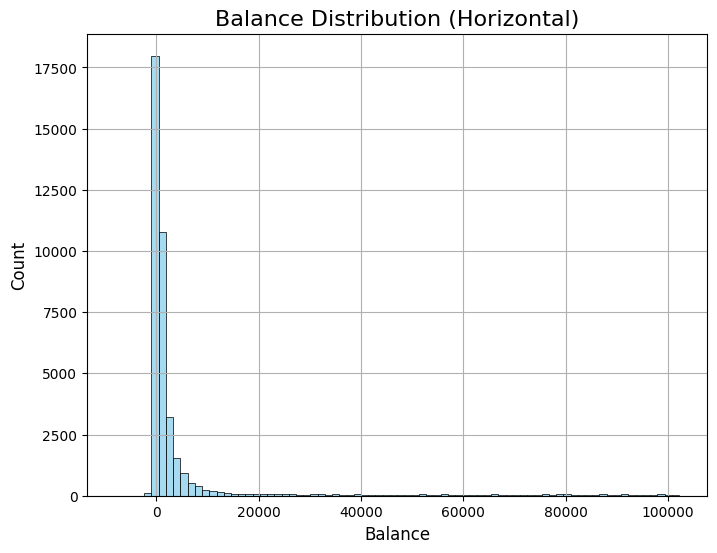

In [44]:
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(8, 6))
sns.histplot(
    data=train_data,              
    x='balance',                
    bins=78,                 
    color='skyblue',        
    edgecolor='black',       
    kde=False,               
    orientation='horizontal'
)
plt.title("Balance Distribution (Horizontal)", fontsize=16)
plt.ylabel("Count", fontsize=12)
plt.xlabel("Balance", fontsize=12)
plt.grid(visible=True)
plt.show()

### Housing

In [45]:
train_data['housing'].value_counts()

housing
yes    21657
no     17554
Name: count, dtype: int64

In [46]:
train_data['housing'].describe()

count     39211
unique        2
top         yes
freq      21657
Name: housing, dtype: object

- The `housing` column has 39,211 entries, with 2 unique values; "yes" is the most frequent, appearing 21,657 times.


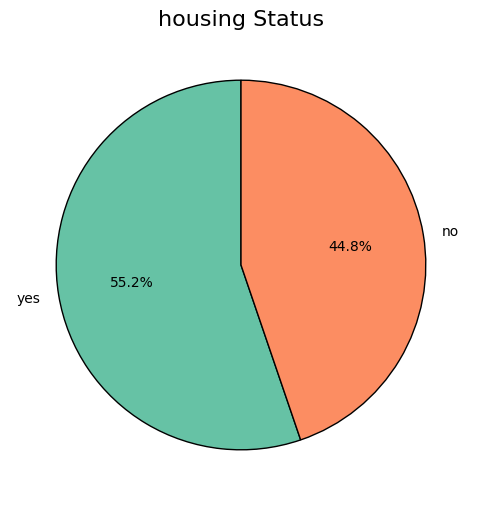

In [47]:
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(8, 6))
housing_counts = train_data['housing'].value_counts()
plt.pie(
    housing_counts.values,           
    labels=housing_counts.index,     
    autopct='%1.1f%%',                 
    colors=sns.color_palette('Set2'),  
    startangle=90,                     
    wedgeprops={'edgecolor': 'black'}   
)
plt.title("housing Status", fontsize=16)
plt.show()

### Loan

In [48]:
train_data['loan'].value_counts()

loan
no     31820
yes     7391
Name: count, dtype: int64

In [49]:
train_data['loan'].describe()

count     39211
unique        2
top          no
freq      31820
Name: loan, dtype: object

- The "loan" column contains 39,211 entries with 2 unique values, where "no" is the most common response, occurring 31,820 times.


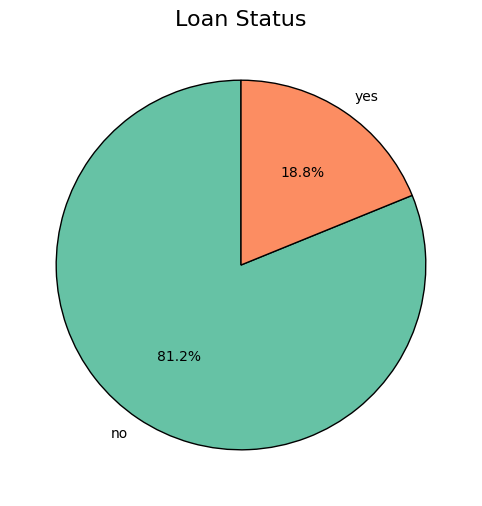

In [50]:
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(8, 6))
loan_counts = train_data['loan'].value_counts()
plt.pie(
    loan_counts.values,          
    labels=loan_counts.index,     
    autopct='%1.1f%%',                 
    colors=sns.color_palette('Set2'), 
    startangle=90,                     
    wedgeprops={'edgecolor': 'black'}   
)
plt.title("Loan Status", fontsize=16)
plt.show()

### Contact

In [51]:
train_data['contact'].value_counts()

contact
cellular     25030
telephone     3845
Name: count, dtype: int64

In [52]:
train_data['contact'].describe()

count        28875
unique           2
top       cellular
freq         25030
Name: contact, dtype: object

- The "contact" column has 28,875 entries with 2 unique values, where "cellular" is the most frequent, appearing 25,030 times.


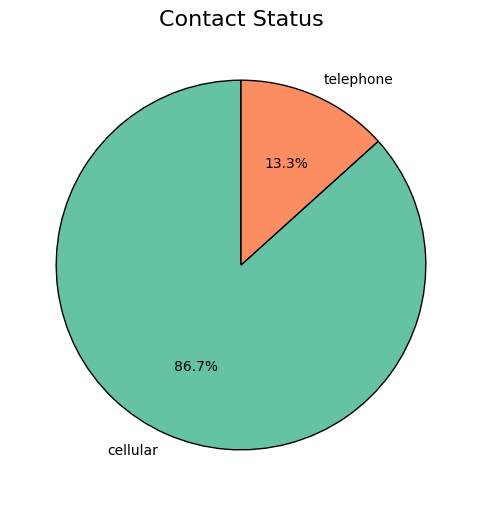

In [53]:
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(8, 6))
contact_counts = train_data['contact'].value_counts()
plt.pie(
    contact_counts.values,           
    labels=contact_counts.index,     
    autopct='%1.1f%%',                 
    colors=sns.color_palette('Set2'),  
    startangle=90,                     
    wedgeprops={'edgecolor': 'black'}   
)
plt.title("Contact Status", fontsize=16)
plt.show()

### Duration

In [54]:
neg_dur=train_data[train_data['duration']<=0]
neg_dur

,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,target,year,month,weekday
11954,2010-05-27,53,management,married,primary,no,351,yes,no,NaN,0,4,-1,0,NaN,no,2010,5,3
28192,2010-08-26,35,technician,married,secondary,no,5535,no,no,cellular,0,15,-1,0,NaN,no,2010,8,3


In [55]:
train_data['duration'].value_counts()

duration
124     162
114     149
90      145
139     145
89      145
       ... 
2303      1
3808      1
1299      1
2054      1
1631      1
Name: count, Length: 3146, dtype: int64

In [56]:
train_data['duration'].describe()

count    39211.000000
mean       439.062789
std        769.096291
min          0.000000
25%        109.000000
50%        197.000000
75%        380.000000
max       4918.000000
Name: duration, dtype: float64

- The "duration" column contains 39,211 entries with a mean of 439.06 and a standard deviation of 769.10, ranging from 0 to 4,918, indicating significant variability in call durations.


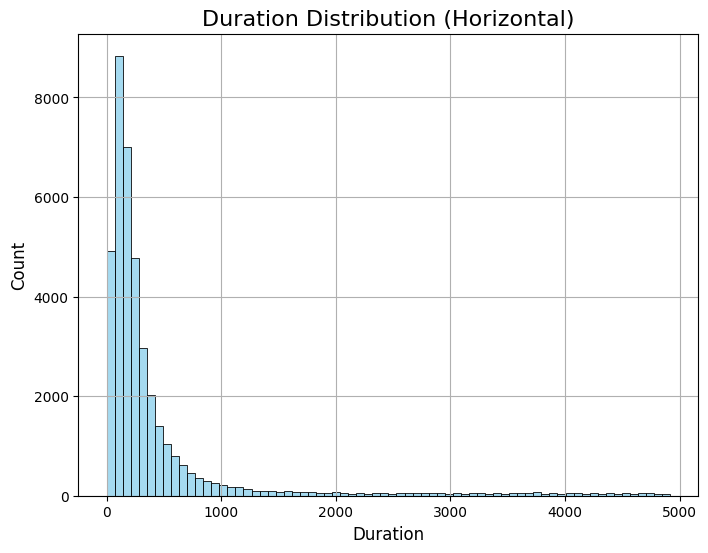

In [57]:
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(8, 6))
sns.histplot(
    data=train_data,              
    x='duration',                 
    bins=70,                 
    color='skyblue',         
    edgecolor='black',       
    kde=False,               
    orientation='horizontal' 
)
plt.title("Duration Distribution (Horizontal)", fontsize=16)
plt.ylabel("Count", fontsize=12)
plt.xlabel("Duration", fontsize=12)
plt.grid(visible=True)
plt.show()

### Campaign

In [58]:
train_data['campaign'].value_counts().sort_index()

campaign
1     14013
2     10016
3      4470
4      2861
5      1469
      ...  
59       50
60       43
61       47
62       50
63       52
Name: count, Length: 63, dtype: int64

In [59]:
train_data[train_data['campaign']<=0].shape[0]


0

In [60]:
train_data['campaign'].describe()

count    39211.000000
mean         5.108770
std          9.890153
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         63.000000
Name: campaign, dtype: float64

- The "campaign" column has 39,211 entries with a mean of 5.11 and a standard deviation of 9.89, with values ranging from 1 to 63, suggesting a wide variation in the number of contacts made during campaigns.


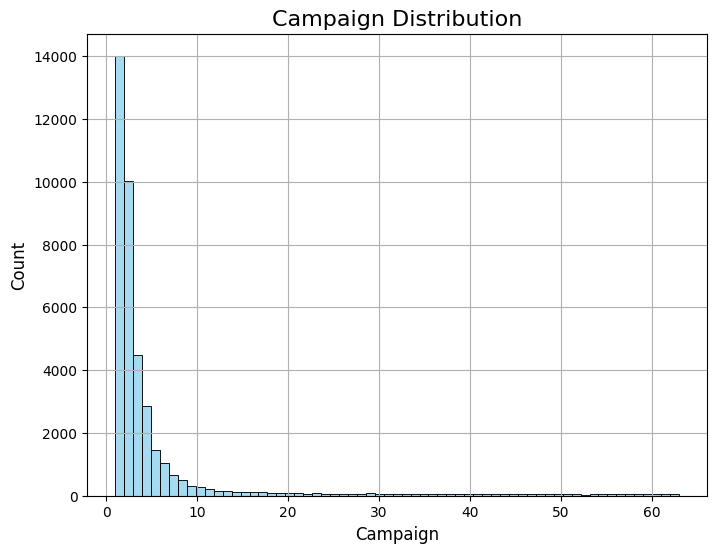

In [61]:
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(8, 6))
sns.histplot(
    data=train_data,                
    x='campaign',                   
    bins=63,                       
    color='skyblue',                
    edgecolor='black',              
    kde=False,                      
)
plt.title("Campaign Distribution", fontsize=16)
plt.ylabel("Count", fontsize=12)
plt.xlabel("Campaign", fontsize=12)
plt.grid(visible=True)
plt.show()

### pdays

In [62]:
train_data['pdays'].describe()

count    39211.000000
mean        72.256051
std        160.942593
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max        871.000000
Name: pdays, dtype: float64

- The "pdays" column contains 39,211 entries with a mean of 72.26 and a standard deviation of 160.94; however, many values are -1, indicating that these clients were not previously contacted, which affects the interpretation of this variable.


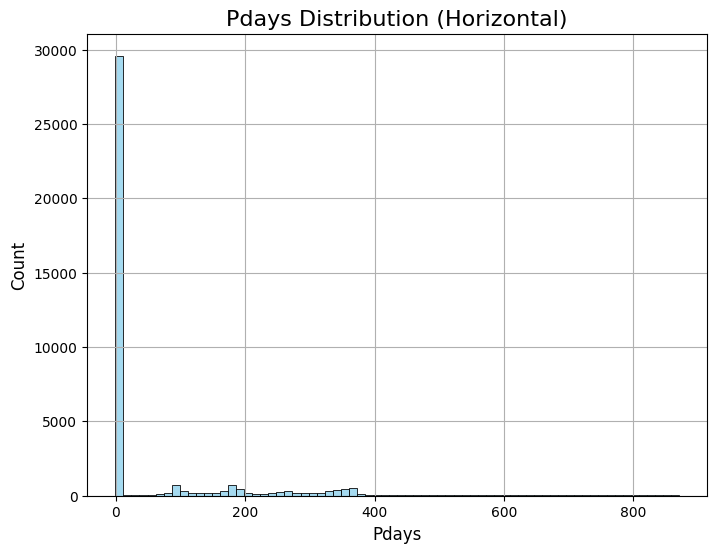

In [63]:
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(8, 6))
sns.histplot(
    data=train_data,              
    x='pdays',                 
    bins=70,                
    color='skyblue',         
    kde=False,               
    orientation='horizontal'
)
plt.title("Pdays Distribution (Horizontal)", fontsize=16)
plt.ylabel("Count", fontsize=12)
plt.xlabel("Pdays", fontsize=12)
plt.grid(visible=True)
plt.show()

### Previous

In [64]:
train_data['previous'].describe()

count    39211.000000
mean        11.826171
std         44.140259
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        275.000000
Name: previous, dtype: float64

- The "previous" column has 39,211 entries with a mean of 11.83 and a standard deviation of 44.14, with most values being 0, indicating that a majority of clients have had no previous contacts in the campaign.


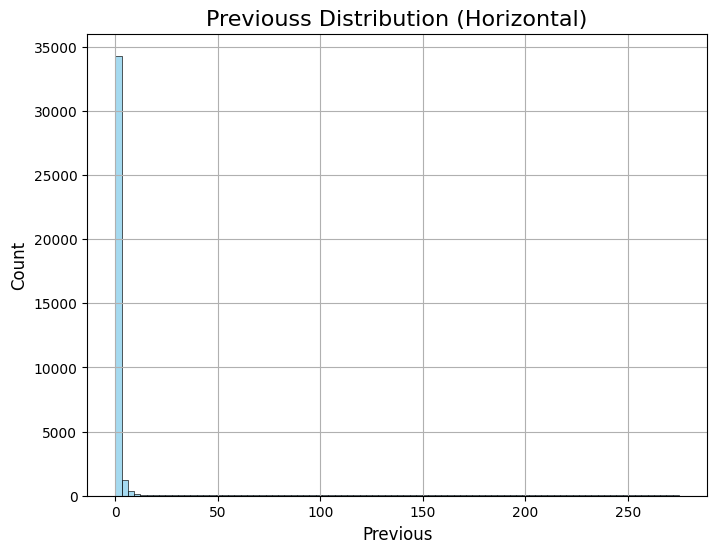

In [65]:
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(8, 6))
sns.histplot(
    data=train_data,              
    x='previous',                 
    bins=90,                 
    color='skyblue',         
    edgecolor='black',      
    kde=False,               
    orientation='horizontal' 
)
plt.title("Previouss Distribution (Horizontal)", fontsize=16)
plt.ylabel("Count", fontsize=12)
plt.xlabel("Previous", fontsize=12)
plt.grid(visible=True)
plt.show()

### Poutcome

In [66]:
train_data['poutcome'].value_counts()

poutcome
failure    4949
other      2560
success    2251
Name: count, dtype: int64

In [67]:
train_data['poutcome'].describe()

count        9760
unique          3
top       failure
freq         4949
Name: poutcome, dtype: object

- The "poutcome" column contains 9,760 entries with 3 unique values, where "failure" is the most frequent outcome, occurring 4,949 times.


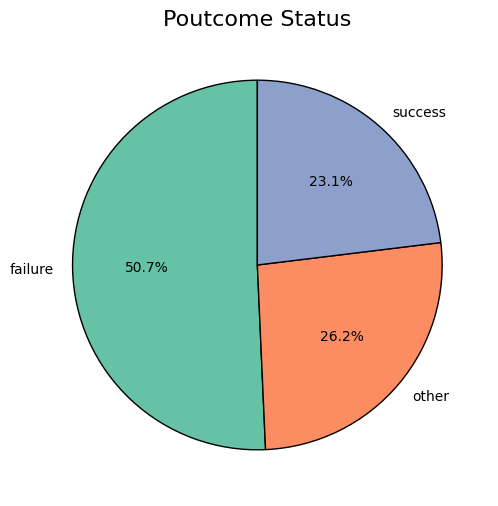

In [68]:
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(8, 6))
poutcome_counts = train_data['poutcome'].value_counts()
plt.pie(
    poutcome_counts.values,           
    labels=poutcome_counts.index,     
    autopct='%1.1f%%',                 
    colors=sns.color_palette('Set2'),  
    startangle=90,                     
    wedgeprops={'edgecolor': 'black'}   
)
plt.title("Poutcome Status", fontsize=16)
plt.show()

### Target 

In [69]:
train_data['target'].describe()

count     39211
unique        2
top          no
freq      33384
Name: target, dtype: object

- The "target" column has 39,211 entries with 2 unique values, where "no" is the most common, appearing 33,384 times.


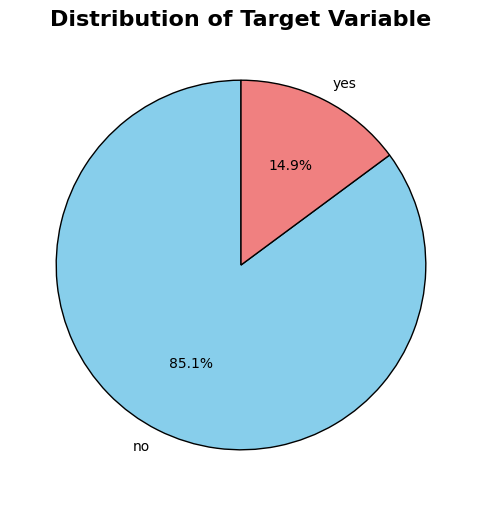

In [70]:
import matplotlib.pyplot as plt
target_counts = train_data['target'].value_counts()
values = target_counts.index.tolist()
proportions = target_counts.values.tolist()
colors = ['skyblue', 'lightcoral']
plt.figure(figsize=(6, 6))  
plt.pie(proportions, labels=values, autopct='%1.1f%%', colors=colors, 
        startangle=90, wedgeprops={'edgecolor': 'black'})  
plt.title("Distribution of Target Variable", fontsize=16, fontweight='bold')
plt.gca().set_aspect('equal')
plt.show()

## Multivariate analysis

### Numerical to Numerical

#### Correlation matrix

<Figure size 1000x600 with 0 Axes>

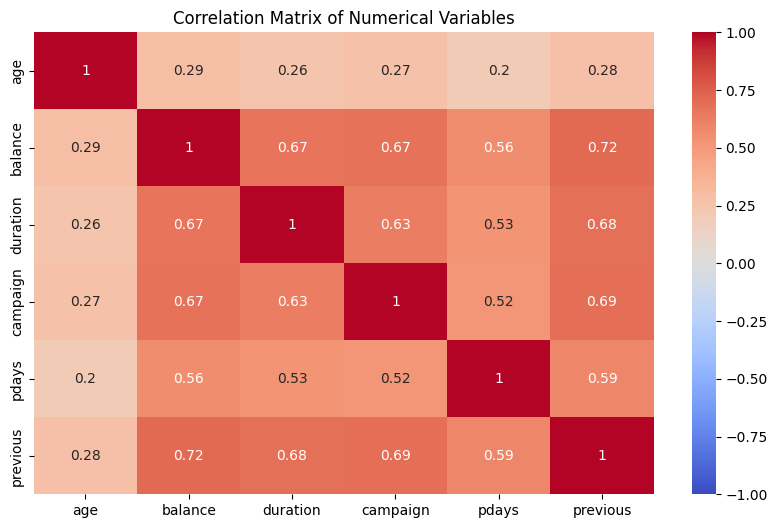

In [71]:
plt.figure(figsize=(10, 6))
numerical_cols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
corr_matrix = train_data[numerical_cols].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numerical Variables')
plt.show()


- The correlation matrix shows moderate to high correlations among balance, duration, campaign, and previous, suggesting redundancy that could benefit from dimensionality reduction, while age has weak correlations with other variables, indicating minimal influence on these attributes.
- Clients' balance, previous contacts, and contact duration have strong positive correlations, while age has weak correlations with other variables.


#### Plot histogram to get the idea about the data and their distributions

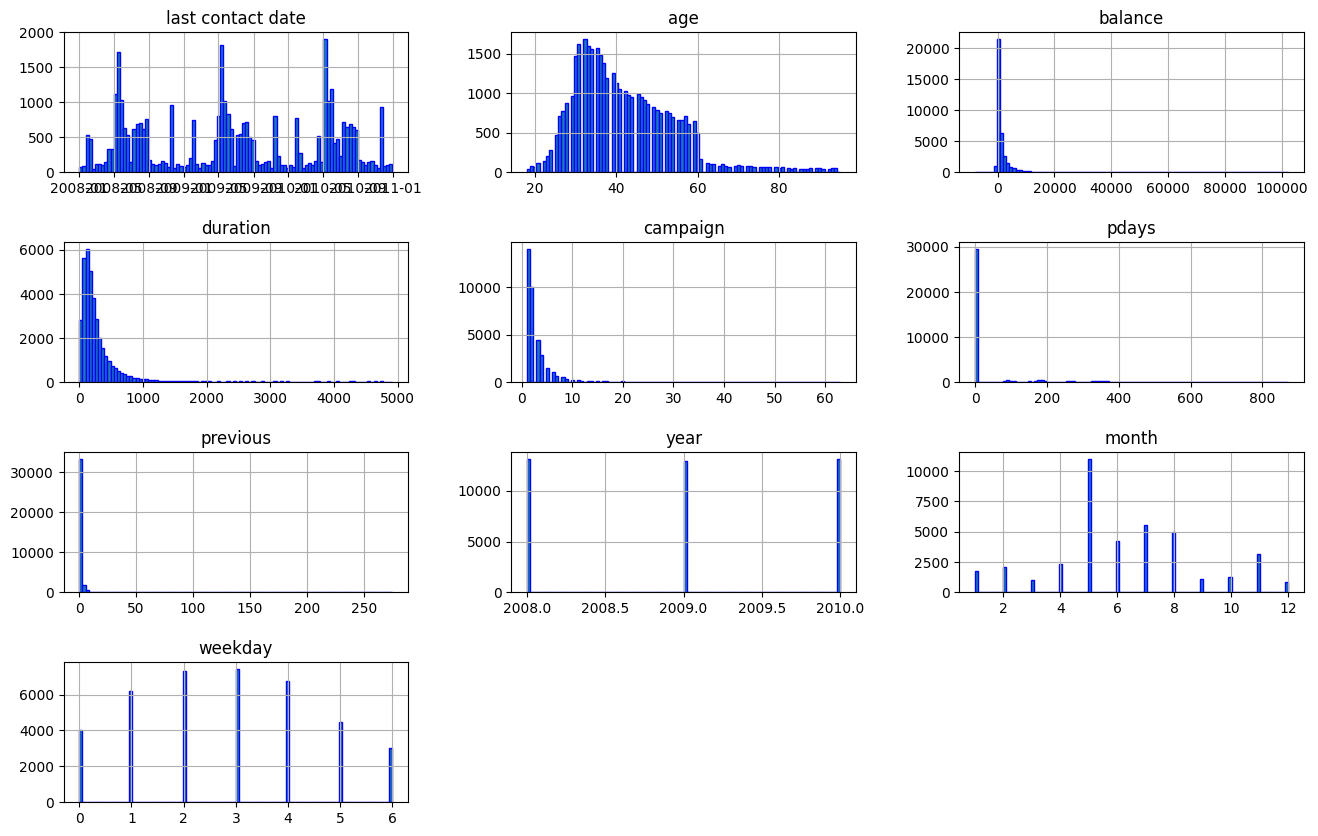

In [72]:
train_data.hist(bins=100,edgecolor='blue', figsize=(16,10))
plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()

#### Age VS Balance

<Figure size 1000x600 with 0 Axes>

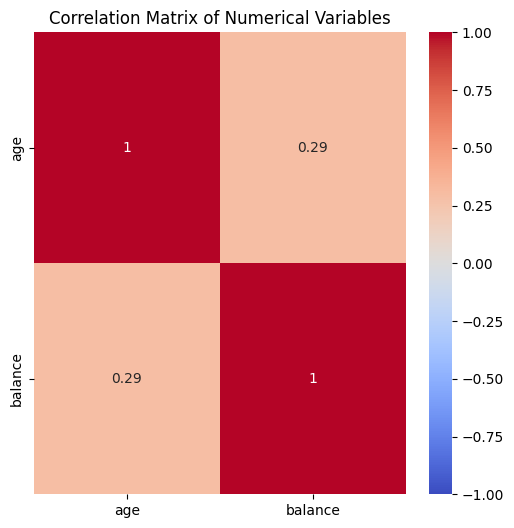

In [73]:
plt.figure(figsize=(10, 6))
numerical_cols = ['age', 'balance']
corr_matrix = train_data[numerical_cols].corr()
plt.figure(figsize=(6, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

#### Duration vs Campaign

<Figure size 1000x600 with 0 Axes>

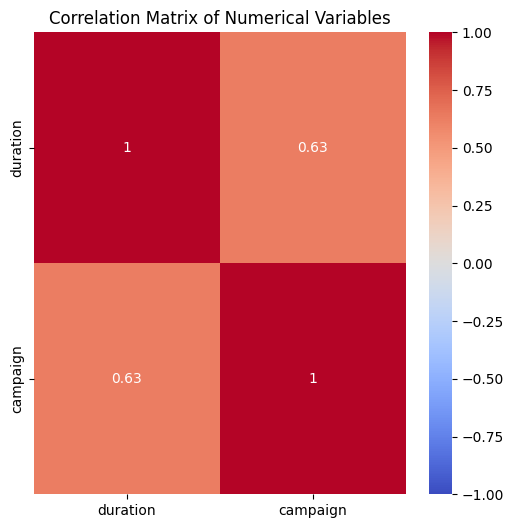

In [74]:
plt.figure(figsize=(10, 6))
numerical_cols = ['duration', 'campaign']
corr_matrix = train_data[numerical_cols].corr()
plt.figure(figsize=(6, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

### Categorical and Numerical

#### Education VS Balance

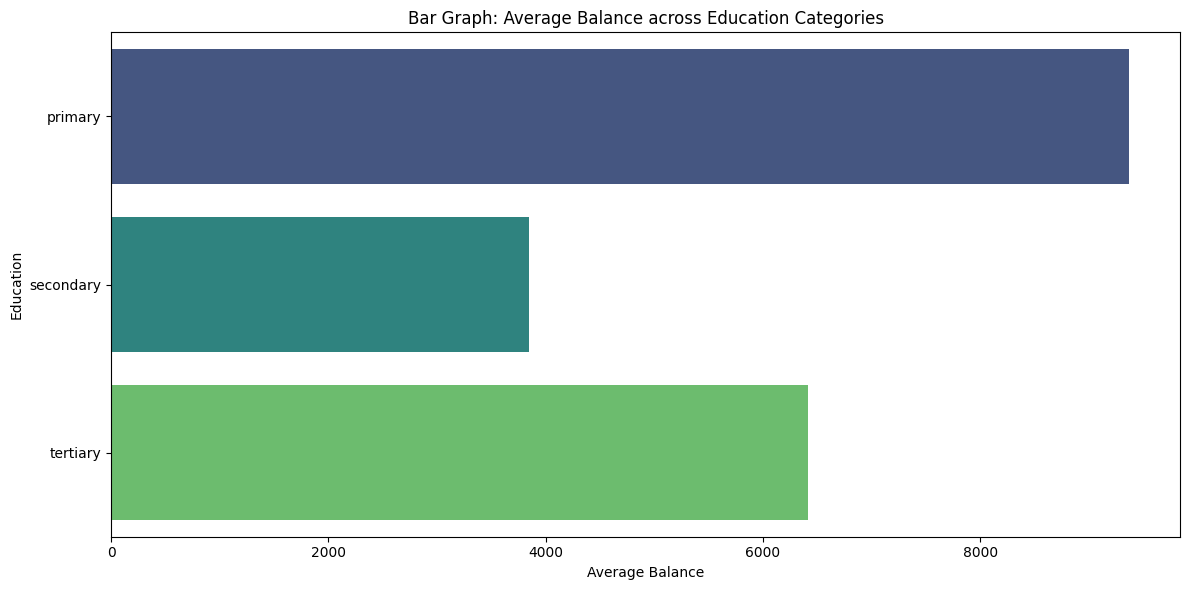

In [75]:
education_balance_mean = train_data.groupby('education')['balance'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='balance', y='education', data=education_balance_mean, palette="viridis")
plt.title('Bar Graph: Average Balance across Education Categories')
plt.xlabel('Average Balance')
plt.ylabel('Education')
plt.tight_layout()
plt.show()


### Categorical vs Categorical

#### Housing vs Default

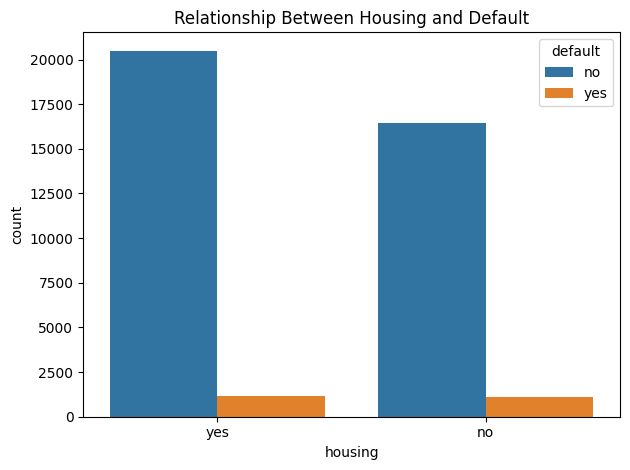

In [76]:
sns.countplot(x='housing', hue='default', data=train_data)
plt.title("Relationship Between Housing and Default")
plt.tight_layout()
plt.show()


- Most of the customer with housing loans are not defaulters.

#### Marital VS Target

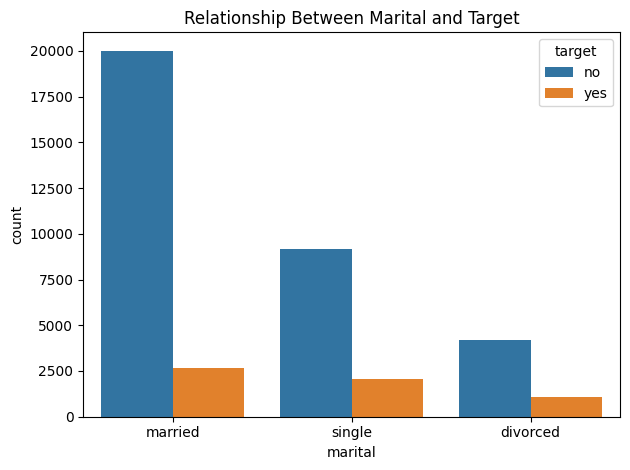

In [77]:
sns.countplot(x='marital', hue='target', data=train_data)
plt.title("Relationship Between Marital and Target")
plt.tight_layout()
plt.show()

# Preprocessing

## Drop last contact data 

In [78]:
train_data = train_data.drop(columns =['last contact date'])

In [79]:
train_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,target,year,month,weekday
0,26,blue-collar,married,secondary,no,647,yes,no,cellular,357,2,331,1,other,no,2009,4,4
1,52,technician,married,secondary,no,553,yes,no,telephone,160,1,-1,0,NaN,no,2009,10,6
2,44,blue-collar,married,secondary,no,1397,no,no,cellular,326,1,-1,0,NaN,no,2010,11,5
3,33,admin.,married,secondary,no,394,yes,no,telephone,104,3,-1,0,NaN,no,2009,9,1
4,31,entrepreneur,single,tertiary,no,137,no,no,cellular,445,2,-1,0,NaN,no,2008,1,1


In [80]:
test_data['last contact date'] = pd.to_datetime(test_data['last contact date'])
test_data['year'] = test_data['last contact date'].dt.year
test_data['month'] = test_data['last contact date'].dt.month
test_data['weekday'] = test_data['last contact date'].dt.weekday

In [81]:
test_data = test_data.drop(columns =['last contact date'])

## Splitting features and target variables

In [82]:
X=train_data.drop(columns=['target'])
y=train_data['target']
X.shape,y.shape

((39211, 17), (39211,))

## Splitting the dataset into training and validation set

In [83]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42 ,stratify=y)

In [84]:
y_val.value_counts()

target
no     6677
yes    1166
Name: count, dtype: int64

In [85]:
train_data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous',
       'poutcome', 'target', 'year', 'month', 'weekday'],
      dtype='object')

## Making pipelines for preprocessing

In [86]:
num  =X.select_dtypes(include = ['int64']).columns
cat  =X.select_dtypes(include = ['object']).columns

In [87]:
ord_col=['year','month','weekday']

In [88]:
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy = 'mean',)),
    ('scaler', StandardScaler())
])
cat_pipe = Pipeline([
    ('imputer', SimpleImputer (strategy='constant', fill_value ='unknown')),
    ('encoder', OneHotEncoder(handle_unknown = 'ignore'))
])
preprocessor = ColumnTransformer(
transformers = [
    ('numerical', num_pipe, num),
    ('categorical', cat_pipe, cat)
],remainder='passthrough')

preprocessor


ColumnTransformer(remainder='passthrough',
                  transformers=[('numerical',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 Index(['age', 'balance', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='unknown',
                                                                strategy='constant')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'poutcome'],
      dtype='object'))])

In [89]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_val_transformed = preprocessor.transform(X_val)
test_data_transformed = preprocessor.transform(test_data)
X_train_transformed = pd.DataFrame(X_train_transformed)
X_val_transformed = pd.DataFrame(X_val_transformed)
test_data_transformed = pd.DataFrame(test_data_transformed)

In [90]:
print(X_train_transformed.shape)
print(X_val_transformed.shape)
print(test_data_transformed.shape)

(31368, 41)
(7843, 41)
(10000, 41)


## FeatureEngineering (after preprocessing)

### PCA(Principal Component Analysis)

In [91]:
pca = PCA(n_components = 30)
X_train_reduced_pca = pca.fit_transform(X_train_transformed)
X_val_reduced_pca = pca.transform(X_val_transformed)
X_test_reduces_pca=pca.transform(test_data_transformed)
X_train_pca = pd.DataFrame(X_train_reduced_pca)
X_val_pca = pd.DataFrame(X_val_reduced_pca)
X_test_pca=pd.DataFrame(X_test_reduces_pca)

In [92]:
print(X_test_reduces_pca.shape)

(10000, 30)


# MODEL

## Logistic Regression

### Model use Pipeline

In [93]:
log_reg = LogisticRegression(max_iter=1000,random_state=0,class_weight='balanced')
log_reg.fit(X_train_transformed, y_train)

y_pred_log_reg = log_reg.predict(X_val_transformed)
log_reg_acc = accuracy_score(y_val, y_pred_log_reg)
log_reg_report = classification_report(y_val, y_pred_log_reg)

print(log_reg_acc)
print(log_reg_report)

0.82060436057631
              precision    recall  f1-score   support

          no       0.95      0.84      0.89      6677
         yes       0.44      0.73      0.55      1166

    accuracy                           0.82      7843
   macro avg       0.69      0.78      0.72      7843
weighted avg       0.87      0.82      0.84      7843



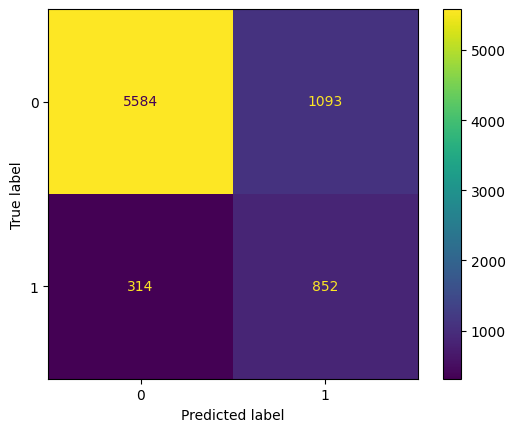

In [94]:
cm=confusion_matrix(y_val,y_pred_log_reg)
cd=ConfusionMatrixDisplay(cm)
cd.plot()

In [95]:
y_pred = log_reg.predict(test_data_transformed)

### Model use PCA

In [96]:
#PCA 

log_reg = LogisticRegression(max_iter=1000,random_state=0,class_weight='balanced')
log_reg.fit(X_train_pca, y_train)
y_pred = log_reg.predict(X_val_pca)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

          no       0.95      0.84      0.89      6677
         yes       0.44      0.73      0.55      1166

    accuracy                           0.82      7843
   macro avg       0.70      0.79      0.72      7843
weighted avg       0.87      0.82      0.84      7843



In [97]:
y_pred_p = log_reg.predict(X_test_pca)

## Random Forest Classifier

In [98]:
rfc = RandomForestClassifier(class_weight = 'balanced', random_state = 0)

### Model use Pipeline

In [99]:
rfc.fit(X_train_transformed, y_train)
y_pred = rfc.predict(X_val_transformed)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

          no       0.89      0.97      0.93      6677
         yes       0.62      0.32      0.43      1166

    accuracy                           0.87      7843
   macro avg       0.76      0.64      0.68      7843
weighted avg       0.85      0.87      0.85      7843



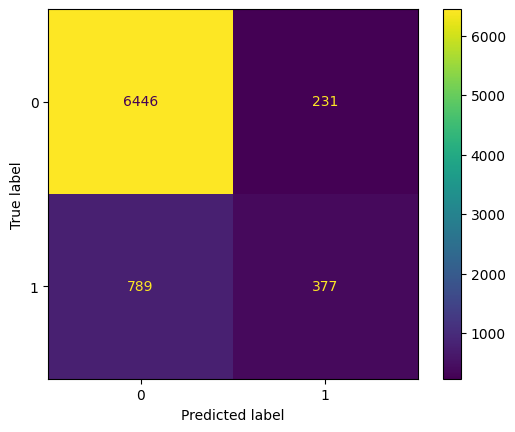

In [100]:
cm=confusion_matrix(y_val,y_pred)
cd=ConfusionMatrixDisplay(cm)
cd.plot()

In [101]:
y_pred = rfc.predict(test_data_transformed)

## XGBClassifier

In [102]:
xgb = XGBClassifier(random_state = 0,scale_pos_weight=3)

In [103]:
y_train = y_train.replace({'yes': 1, 'no': 0})
y_val = y_val.replace({'yes': 1, 'no': 0})

In [104]:
xgb.fit(X_train_transformed, y_train)
y_pred_val = xgb.predict(X_val_transformed)
print(classification_report(y_val, y_pred_val))
print(roc_auc_score(y_val, y_pred_val))

              precision    recall  f1-score   support

           0       0.95      0.88      0.92      6677
           1       0.52      0.73      0.61      1166

    accuracy                           0.86      7843
   macro avg       0.74      0.81      0.76      7843
weighted avg       0.89      0.86      0.87      7843

0.8061799022835361


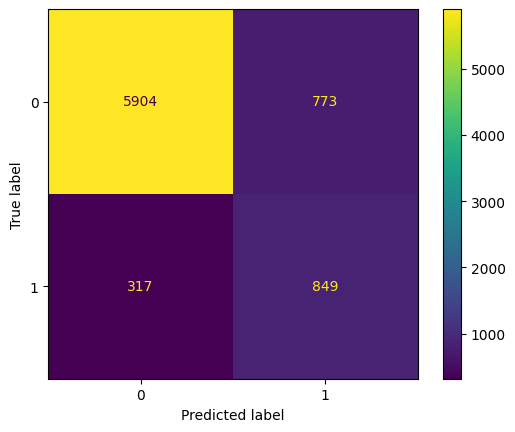

In [105]:
cm=confusion_matrix(y_val,y_pred_val)
cd=ConfusionMatrixDisplay(cm)
cd.plot()

In [106]:
y_pred = xgb.predict(test_data_transformed)

- this model give me high f1-macro

### Hyper Parameter Tuning for XGBClassifier

In [107]:
# log_reg = LogisticRegression(max_iter=1000, random_state=42,class_weight='balanced')
# xgb = XGBClassifier(random_state = 42,scale_pos_weight=4)
# lgbm_mod = LGBMClassifier(random_state=42)

# stacking_clf = StackingClassifier(
#     estimators=[
#         ('log_reg', log_reg),
#         ('xgb', xgb),
#         ('lgbm', lgbm_mod)
#     ],
#     final_estimator=LogisticRegression(max_iter=1000,random_state=42,class_weight='balanced'),  
#     cv=5,
#     verbose=3,
#     n_jobs=-1
# )

# stacking_clf.fit(X_train_transformed1, y_train)
# y_pred_stack = stacking_clf.predict(X_val_transformed1)
# stack_acc = accuracy_score(y_val, y_pred_stack)
# stack_report = classification_report(y_val, y_pred_stack)

# print(f"Stacking Model Accuracy: {stack_acc}")
# print("Classification Report:\n", stack_report)

In [108]:
# y_pred = grid_search.predict(test_data_transformed)

In [113]:
log_reg = LogisticRegression(max_iter=1000, random_state=42,class_weight='balanced')
xgb = XGBClassifier(random_state = 42,scale_pos_weight=4)
lgbm_mod = LGBMClassifier(random_state=42)

stacking_clf = StackingClassifier(
    estimators=[
        ('log_reg', log_reg),
        ('xgb', xgb),
        ('lgbm', lgbm_mod)
    ],
    final_estimator=LogisticRegression(max_iter=1000,random_state=42,class_weight='balanced'),  
    cv=5,
    verbose=3,
    n_jobs=-1
)

stacking_clf.fit(X_train_transformed, y_train)
y_pred_stack = stacking_clf.predict(X_val_transformed)
stack_acc = accuracy_score(y_val, y_pred_stack)
stack_report = classification_report(y_val, y_pred_stack)

print(f"Stacking Model Accuracy: {stack_acc}")
print("Classification Report:\n", stack_report)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.6s remaining:    2.3s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


[LightGBM] [Info] Number of positive: 3728, number of negative: 21366
[LightGBM] [Info] Number of positive: 3729, number of negative: 21365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1235
[LightGBM] [Info] Number of data points in the train set: 25094, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148561 -> initscore=-1.745929
[LightGBM] [Info] Start training from score -1.745929
[LightGBM] [Info] Number of positive: 3729, number of negative: 21366
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1234
[LightGBM] [Info] Number of positive: 3729, number of negative: 21365
[LightGBM] [Info] Number of data poin

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.8s finished


[LightGBM] [Warning] Detected that num_threads changed during training (from 2 to 1), it may cause unexpected errors.


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.7s remaining:    4.0s


[LightGBM] [Info] Number of positive: 3729, number of negative: 21366
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1238
[LightGBM] [Info] Number of data points in the train set: 25095, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148595 -> initscore=-1.745661
[LightGBM] [Info] Start training from score -1.745661


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.1s remaining:    6.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.2s finished


Stacking Model Accuracy: 0.8505673849292362
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.85      0.91      6677
           1       0.50      0.84      0.63      1166

    accuracy                           0.85      7843
   macro avg       0.73      0.85      0.77      7843
weighted avg       0.90      0.85      0.86      7843



In [114]:
y_pred = stacking_clf.predict(test_data_transformed)

## Submission

In [115]:
y_train = y_train.replace({1:'yes', 0:'no'})
y_val = y_val.replace({1:'yes', 0:'no'})

In [116]:
y_pred = np.where(y_pred == 1, 'yes', 'no')

In [117]:
submission=pd.DataFrame({'id':range(0,test_data.shape[0]),'target':y_pred})
submission.to_csv('submission.csv',index=False)

In [118]:
submission.shape

(10000, 2)

[LightGBM] [Info] Number of positive: 4661, number of negative: 26707
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1237
[LightGBM] [Info] Number of data points in the train set: 31368, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148591 -> initscore=-1.745696
[LightGBM] [Info] Start training from score -1.745696


# Comparison of model

In [ ]:
# models = {
#     'XGBoost': XGBClassifier(random_state = 0,scale_pos_weight=3),
#     'Logistic Regression': LogisticRegression(max_iter=1000,random_state=0,class_weight='balanced')
# }

# f1_scores, accuracies = [], []
# for name, model in models.items():
#     model.fit(X_train_transformed, y_train)
#     y_pred = model.predict(X_val_transformed)
#     f1_scores.append(f1_score(y_val, y_pred, average='macro'))
#     accuracies.append(accuracy_score(y_val, y_pred))

# sns.set(style='whitegrid')
# fig, ax = plt.subplots(figsize=(12, 6))
# x = range(len(models))
# width = 0.25

# ax.bar([i - width for i in x], f1_scores, width, label='F1-Macro', color='skyblue')
# ax.bar([i + width for i in x], accuracies, width, label='Accuracy', color='lightgreen')

# ax.set_xlabel('Models', fontsize=14)
# ax.set_ylabel('Score', fontsize=14)
# ax.set_title('Model Comparison: F1-Macro and Accuracy', fontsize=16)
# ax.set_xticks(x)
# ax.set_xticklabels(models.keys(), fontsize=12)
# ax.legend(loc='best')

# for i, (f1, acc) in enumerate(zip(f1_scores, accuracies)):
#     ax.text(i - width, f1 + 0.01, f'{f1:.2f}', ha='center', fontsize=10)
#     ax.text(i + width, acc + 0.01, f'{acc:.2f}', ha='center', fontsize=10)

# plt.show()
